# How to overcome limitations of principal component analysis

Principal component analysis and independent component analysis is often uset to reduce the dimensionality of textures and images. However, the base images returned by the PCA and ICA algorithms must fit for all texture patches extracted from the image. As a result, these algorithms cannot recognise patterns that are occuring in different positions of texture patches. In the following we expore how clustering can be used to address this problem. 

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hclust 
import sklearn

from pandas import Series
from pandas import DataFrame

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import uniform 

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Local imports
from common import *
from convenience import *

## I. Why PCA fails on stars and stripes 

In the following we sythesise two example images for which PCA does not return the best base images. The first one consists of randomly placed blobs and the second consists of horisontal stripes.

### Syntesis of blobed images

In [2]:
def blob_texture(d: int=5)->np.array:
    """Creates a blob with radius d in pixels"""
    
    x, y = np.meshgrid(range(-d, d + 1), range(-d, d + 1))
    return (np.round(np.sqrt(x**2+ y**2)) <= d).astype(float)

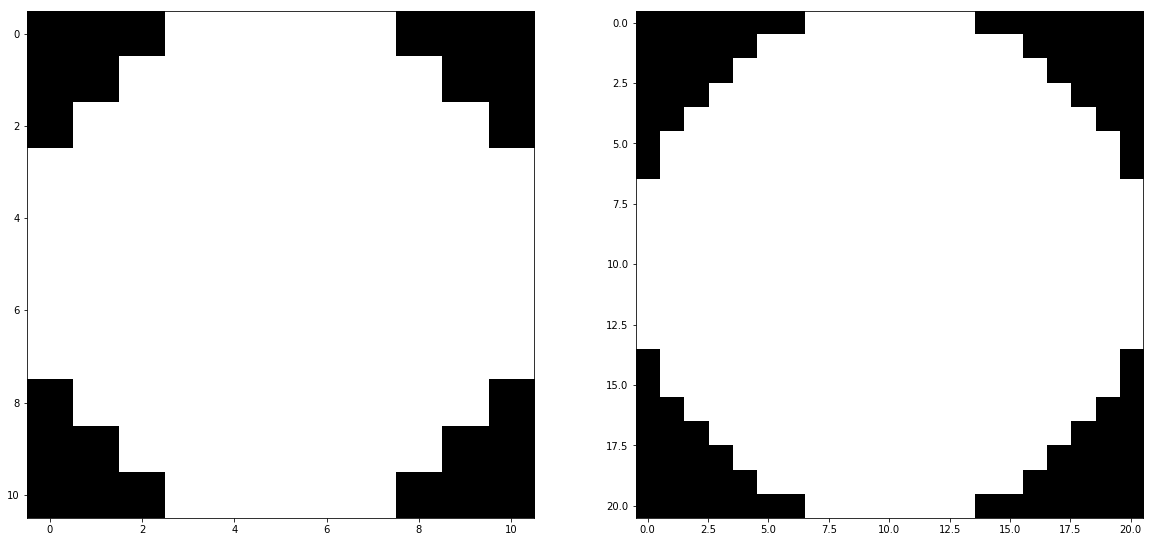

In [3]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(blob_texture(), cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(blob_texture(10), cmap = 'gray')

In [4]:
def blob_pattern(m:int=500, n:int=500, d:int=5, k:int=50) -> np.array:
    """Returns m x n image where k blobs with the radius d are located at random locations"""
    
    x = rnd.choice(range(d, m - d), size=k, replace=True)
    y = rnd.choice(range(d, n - d), size=k, replace=True)

    blob = blob_texture(d) == 1
    image = np.full([m, n], 0)
    for i in range(k):
        image[x[i] - d: x[i] + d + 1, y[i] - d: y[i] + d + 1] |= blob
    
    return image.astype(float)

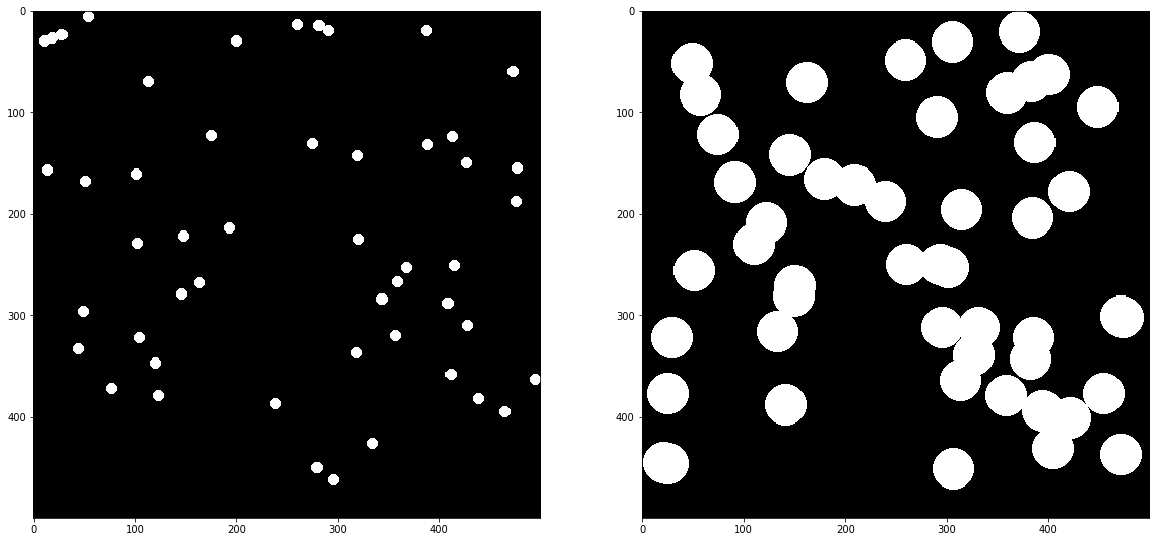

In [5]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(blob_pattern(d=5), cmap ='gray')  
fig.add_subplot(1, 2, 2)
plt.imshow(blob_pattern(d=20), cmap ='gray')  

### Synthesis of horisontally striped images

In [6]:
def regular_stripe_pattern(m:int=500, n:int=500, d:int=1, k:int=50) -> np.array:
    """Returns m x n image where k stripes with the diameter 2d are regularly placed"""
    
    assert(np.floor(m/k) > 2 * d + 1)
    h = np.floor(m/k)
    y = (range(1, k) * h).astype(int) 
    
    image = np.full([m, n], 0)
    for i in range(k - 1):
        image[y[i] - d: y[i] + d + 1, :] = 1
    return image.astype(float)

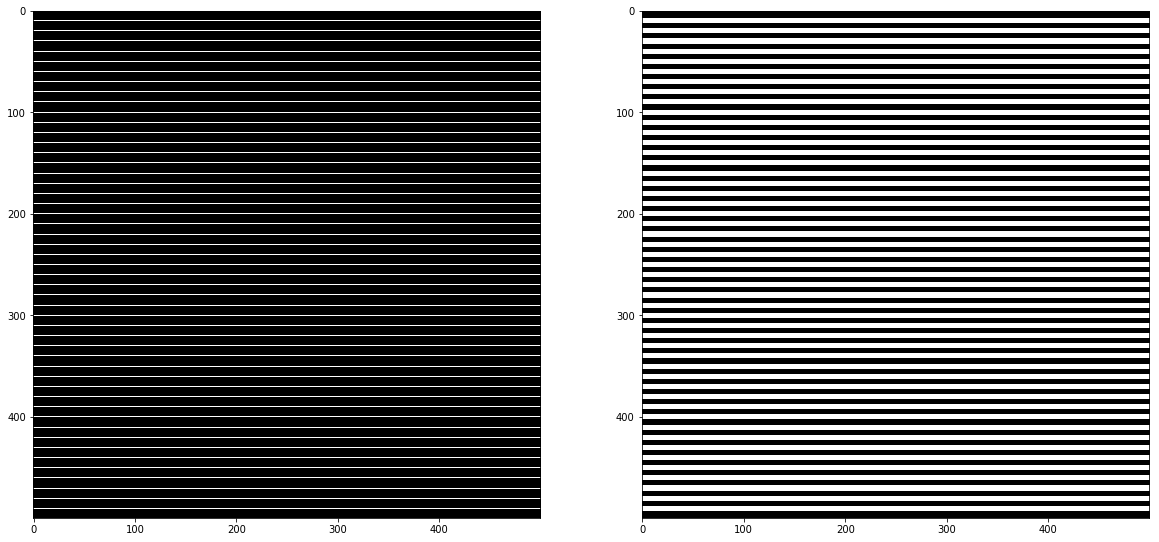

In [7]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(regular_stripe_pattern(d=0), cmap ='gray')  
fig.add_subplot(1, 2, 2)
plt.imshow(regular_stripe_pattern(d=2), cmap ='gray')  

### Texture extraction from random locations 

In [8]:
def extract_texture_vectors(bw_image: np.array, k: int=1000, d: int=10) -> DataFrame:
    
    m, n = bw_image.shape
    
    #(d <= x) & (x < m - d) & (d <= y) & (y < n - d)
    xm = rnd.choice(range(d, m - d), size=k, replace=True)
    ym = rnd.choice(range(d, n - d), size=k, replace=True)
        
    x0 = xm - d
    x1 = xm + d + 1
    y0 = ym - d
    y1 = ym + d + 1
    
    r = len(xm)
    textures = np.empty([r, (2 * d + 1)**2])
    for i in range(r):
        textures[i, :] = bw_image[x0[i]:x1[i], y0[i]:y1[i]].flatten()
        
    columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)]   
    return (DataFrame(textures, columns = columns)
            .assign(xm = Series(xm).astype(int))
            .assign(ym = Series(ym).astype(int))
            [['xm', 'ym'] + columns])

In [9]:
blobs = blob_pattern()
stripes = regular_stripe_pattern()
blob_textures = extract_texture_vectors(blobs, d=5)
stripe_textures = extract_texture_vectors(stripes, d=5)
head(blob_textures)

,xm,ym,x01,x02,x03,x04,x05,x06,x07,x08,...,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121
0,125,286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,206,429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,336,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,398,455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Principal component analysis of textures

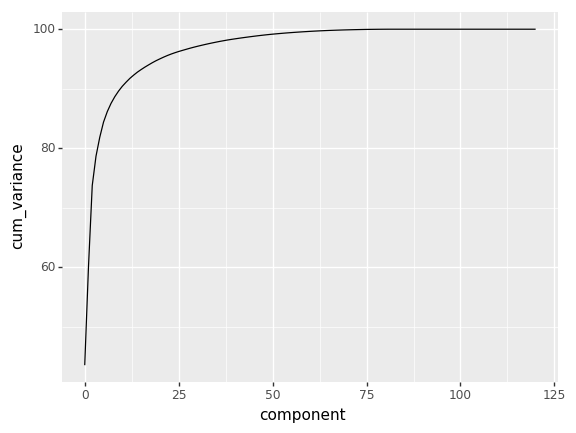

<ggplot: (-9223372029310191321)>

In [10]:
pca = PCA()
pca.fit(blob_textures.iloc[:,2:])

W = DataFrame(pca.components_, columns=blob_textures.columns.values[2:])

rel_var = (DataFrame(100 * pca.explained_variance_ratio_, columns = ['variance'])
           .assign(cum_variance = lambda df: df['variance'].cumsum())
           .assign(component = lambda df: df.index.values)
           [['component', 'variance', 'cum_variance']])

p = ggplot(rel_var)
p = p + geom_line(aes(x = 'component', y = 'cum_variance'))
display(p)

As you can see the base images returned by the PCA are not various shifts of the blob shape -- blobs have definite borders base images have fuzzy border. This occurs as blobs are shifted in the texture window.

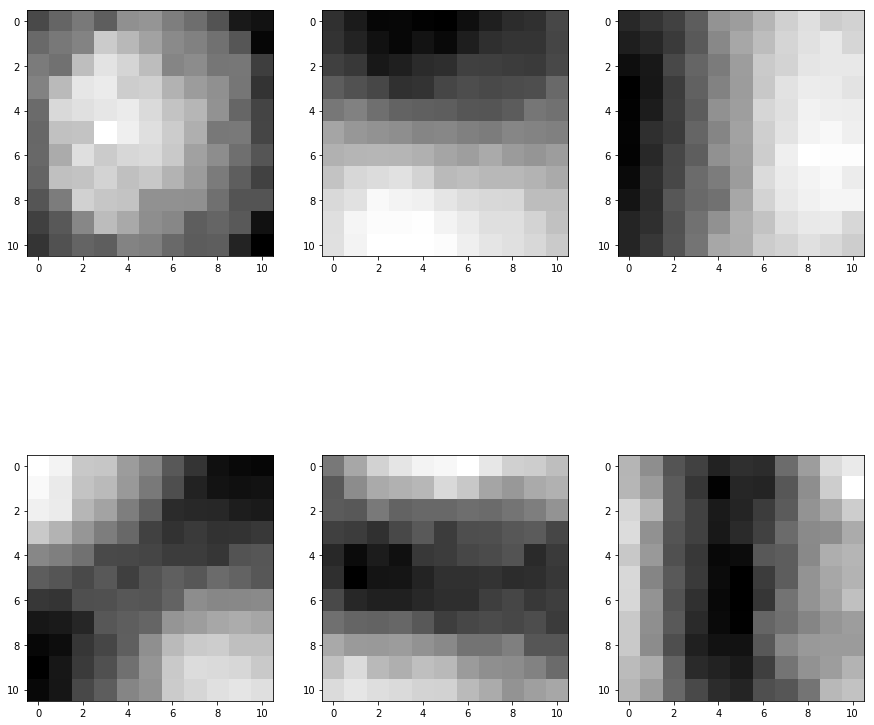

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(W.loc[0, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(232)
plt.imshow(W.loc[1, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(233)
plt.imshow(W.loc[2, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(234)
plt.imshow(W.loc[3, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(235)
plt.imshow(W.loc[4, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(236)
plt.imshow(W.loc[5, :].values.reshape([11,11]), cmap ='gray')

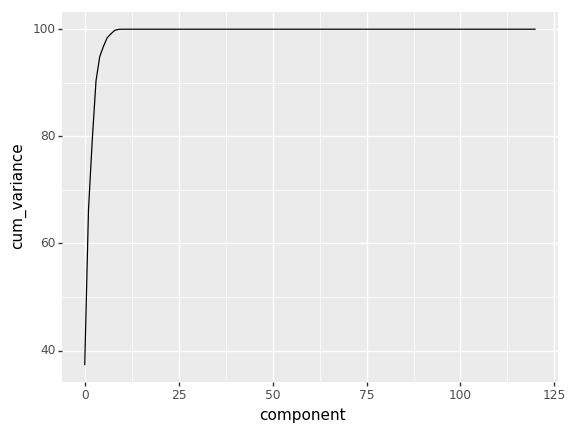

<ggplot: (-9223372029310191293)>

In [12]:
pca = PCA()
pca.fit(stripe_textures.iloc[:,2:])

W = DataFrame(pca.components_, columns=blob_textures.columns.values[2:])

rel_var = (DataFrame(100 * pca.explained_variance_ratio_, columns = ['variance'])
           .assign(cum_variance = lambda df: df['variance'].cumsum())
           .assign(component = lambda df: df.index.values)
           [['component', 'variance', 'cum_variance']])

p = ggplot(rel_var)
p = p + geom_line(aes(x = 'component', y = 'cum_variance'))
display(p)

The same issue occurs also with the regular stryped pattern -- random shifts of stripes in the texture window make it impossible to recover the pattern. 

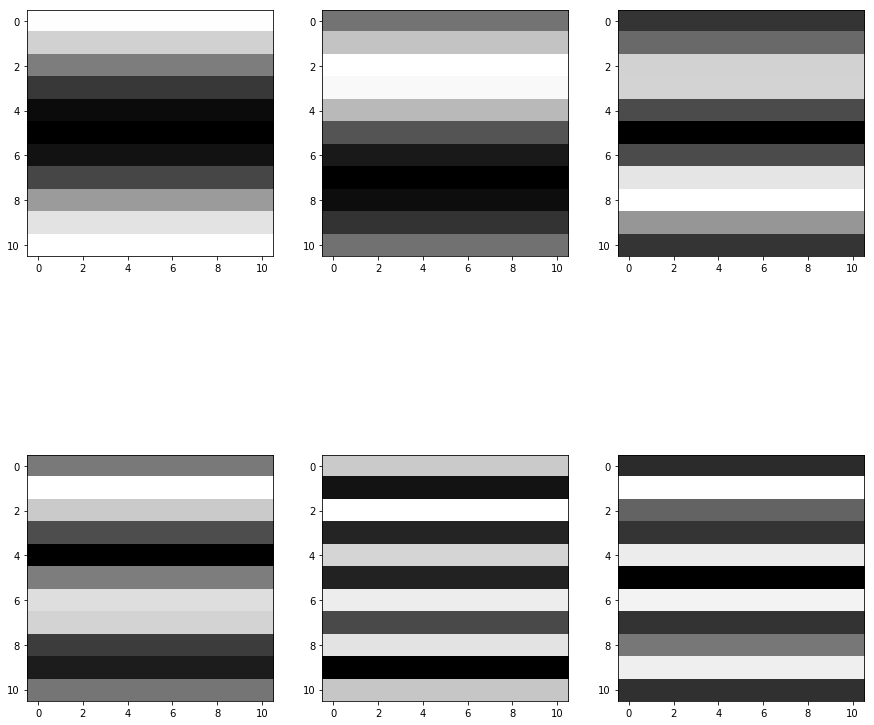

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(W.loc[0, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(232)
plt.imshow(W.loc[1, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(233)
plt.imshow(W.loc[2, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(234)
plt.imshow(W.loc[3, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(235)
plt.imshow(W.loc[4, :].values.reshape([11,11]), cmap ='gray')
plt.subplot(236)
plt.imshow(W.loc[5, :].values.reshape([11,11]), cmap ='gray')

## II. Pattern recovery with naive model based clustering

To mitigate the effect of shifts we can split the images into several clusters. For horisontally striped images the required number of clusters is 11 as there are only so many possible shifts. For blob textures we must consider $11\times 11$ clusters to recover all possible shifts. 

### Cluster model

We assume that textures in a cluster are describable with the first principal image and all deviations are caused by additive spherical gaussian noise $\mathcal{N}(\boldsymbol{0}, \sigma\boldsymbol{\mathrm I})$. More formally
$\boldsymbol{y} = \boldsymbol{\mu}+\xi\cdot \boldsymbol{w} + \boldsymbol{\varepsilon}$ for $\boldsymbol{\varepsilon}\sim\mathcal{N}(\boldsymbol{0}, \sigma\boldsymbol{\mathrm I})$ and thus the log-likelihood is proportional to the mean square plus a constant term that is the same for all clusters. 
Hence, the assignment to the clusters can be done based on mean square error. 



### Mean square error and correlation

Let $\boldsymbol{y}$ be the value to be approximated and $\boldsymbol{w}$ is the ortogonal principal image. Then $\xi=\boldsymbol{w}^T\boldsymbol{y}$ and thus

\begin{align*}
 ||\boldsymbol{y}-\boldsymbol{\mu}-\xi\cdot \boldsymbol{w}||^2=||\boldsymbol{y}-\boldsymbol{\mu}||^2
- 2 \boldsymbol{w}^T(\boldsymbol{y}-\boldsymbol{\mu})\cdot \boldsymbol{w}^T(\boldsymbol{y}-\boldsymbol{\mu})+ ||\boldsymbol{w}||^2\enspace.
\end{align*}

If we consider a simplified model where $\boldsymbol{\mu}=\boldsymbol{0}$ then the distance is minimised for the cluster which maximises the convolution $\boldsymbol{w}^T\boldsymbol{y}$ between the cluster mask $\boldsymbol{w}$ and texture $\boldsymbol{y}$. Thus you can think of the clusters as convolutional masks.  

# Homework

## 5.1 Implentation of naive clustering with a single PCA component (<font color='red'>2p</font>)

Implement standard two-step maximisation algorithm that implements naive clustering model.
Test is on the blob and striped images? Do the corresponding base images have now more clear interpretation.  


## 5.2. Enhancement that forces shifts of a single base pattern* (<font color='red'>5p</font>)

The naive implementation is not good as the number of clusters quicly explodes. Moreover, the naive algorithm does not assure that clusters contain the shifts of the same pattern. We must force it. Let the texture be $2d+1\times 2d+1$ square. Then we can assuma that underlyung pattern can have shifts in the range $[-d,d]$ and thus the underlying pattern is of size $4d+1\times 4d+1$ and we observe only a shifted subimage of it. Again we can state the clustering model as before however we just do not observe all possible pixels. As the values are missing completely random. We can still assign the textures to clusters based on mean square error. The only difficult part is the recovery of the optimal image that explains all clusters simultaneously. This can be still done using the formulation of PCA however we must compute the correlation matrix in the presence of missing values. Direct optimisation is also possible. 


## 5.2. Enhancement that forces cyclic shifts of a single base pattern* (<font color='red'>4p</font>)

The naive implementation is not good as the number of clusters quicly explodes. Moreover, the naive algorithm does not assure that clusters contain the shifts of the same pattern. We must force it. Nmely we assum that base patterns of all clusters are cyclic shits of the same base pattern. This is clearly justified for repeating textures. Cycic shifts mean that we can estimate the base pattern by undoing all cyclic shifts for all textures and then doing PCA directly.
